In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
instruments = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax", "tru", "vio", "voi"]

path = '../../DataLumenDS/Processed/'

df = pd.DataFrame(columns=['data', 'label'])

for instrument in instruments:
    for root, _, files in os.walk(path + instrument):
        for file in files:
            file_path = os.path.join(root, file)
            data = np.load(file_path)
            data = np.array(data)
            data = data.reshape((data.shape[0], data.shape[1], 1))
            temp = pd.DataFrame({'data': [data], 'label': 1 if instrument == "cel" else 0})
            df = pd.concat([df, temp])

        break

In [5]:
df['data'].shape

(26820,)

In [7]:
temp_cellist = df[df['label'] == 1]
temp_non_cellist = df[df['label'] == 0]

X_train, X_test, y_train, y_test = train_test_split(temp_cellist['data'], temp_cellist['label'], test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(temp_non_cellist['data'], temp_non_cellist['label'], test_size=0.2, random_state=42)


X_train = pd.concat([X_train, X_train2[:310*4]])
X_test = pd.concat([X_test, X_test2])
y_train = pd.concat([y_train, y_train2[:310*4]])
y_test = pd.concat([y_test, y_test2])

X_train = np.stack(X_train)
X_test = np.stack(X_test)
y_train = np.stack(y_train)
y_test = np.stack(y_test)


C:\Users\Karlo\AppData\Local\Temp\ipykernel_10972\264095957.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_train = pd.concat([X_train, X_train2[:310*4]])
C:\Users\Karlo\AppData\Local\Temp\ipykernel_10972\264095957.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train = pd.concat([y_train, y_train2[:310*4]])


In [9]:
X_train.shape

(2481, 513, 33, 1)

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(513, 33, 1)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 511, 31, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 509, 29, 16)       2320      
                                                                 
 flatten (Flatten)           (None, 236176)            0         
                                                                 
 dense (Dense)               (None, 128)               30230656  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 30,233,265
Trainable params: 30,233,265
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile('Adam', loss='BinaryCrossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, 
                    validation_data=(X_test, y_test))

Epoch 1/5
78/78 [==============================] - 58s 742ms/step - loss: 0.9492 - accuracy: 0.6207 - val_loss: 0.4983 - val_accuracy: 0.7267
Epoch 2/5
78/78 [==============================] - 61s 781ms/step - loss: 0.5464 - accuracy: 0.7416 - val_loss: 0.7244 - val_accuracy: 0.5543
Epoch 3/5
78/78 [==============================] - 59s 753ms/step - loss: 0.3996 - accuracy: 0.8279 - val_loss: 0.5197 - val_accuracy: 0.7363
Epoch 4/5
78/78 [==============================] - 58s 745ms/step - loss: 0.2298 - accuracy: 0.9162 - val_loss: 0.4395 - val_accuracy: 0.8071
Epoch 5/5
78/78 [==============================] - 57s 738ms/step - loss: 0.0712 - accuracy: 0.9863 - val_loss: 0.4031 - val_accuracy: 0.8380


168/168 - 16s - loss: 0.4031 - accuracy: 0.8380 - 16s/epoch - 97ms/step


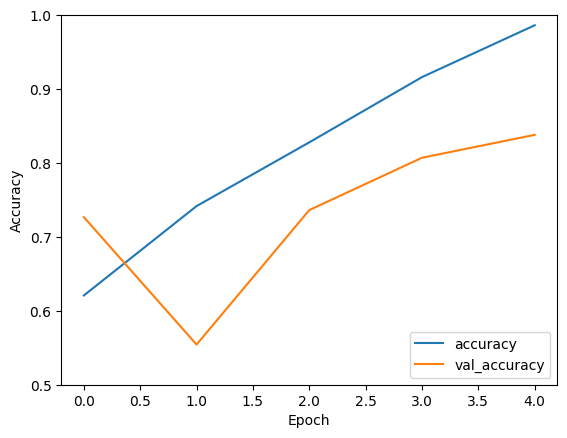

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [15]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 


Saved model to disk


In [ ]:

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")